# Introduction

## Python Imports

In this project the following imports were used:

In [1]:
import skimage.io as io
import skimage.color as cl
import skimage.feature as feat
import  numpy as np
import scipy as sp
import matplotlib.pyplot as plt

## Gray EURion star image

The first step is to have a 2D Gray pattern of the EURion constellation 'star'. The RGB is imported from [1],  then converted to a grayscale binary image (0 for black and 1 for white)

In [2]:
img = io.imread('EURion_point.png')
gray = cl.rgb2gray(img[:,:,:3])

print(f'Maximum gray value in the image: {max(gray.flatten())}')
print(f'Minimum gray value in the image: {min(gray.flatten())}')

Maximum gray value in the image: 1.0
Minimum gray value in the image: 0.607350980392157


It seems the gray image is made of values between 0.6 and 1. A binary filter with threshold 0.9 is applied to simplify and sharpen the pattern. The image is also truncated to only keep the pattern in the image.

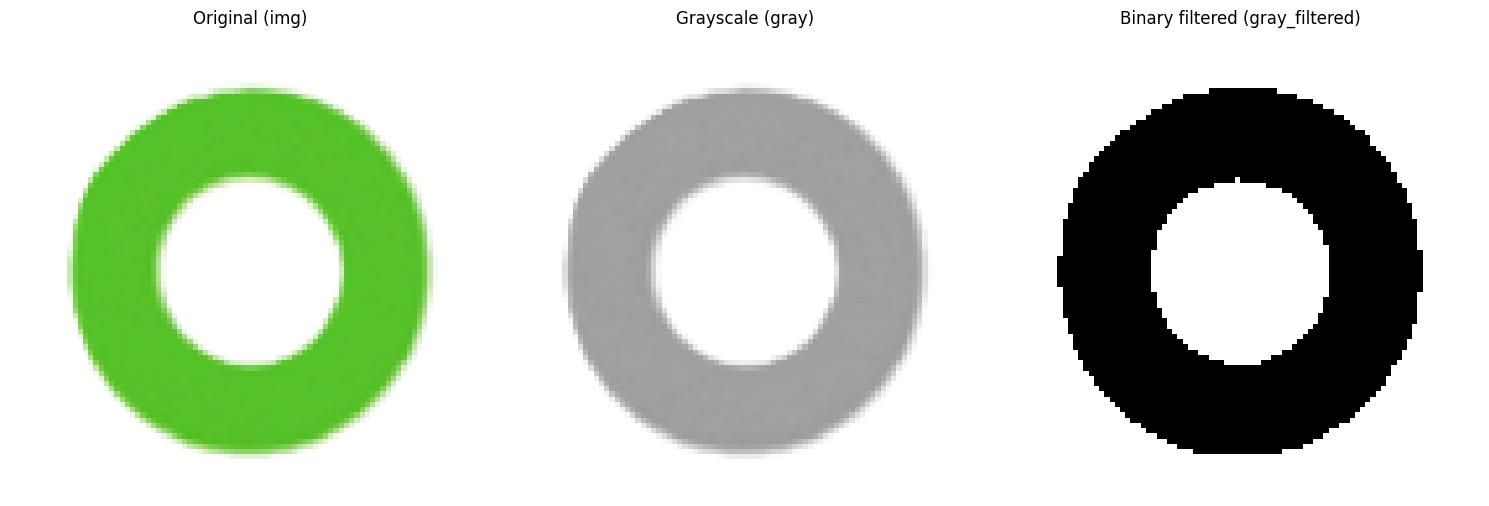

In [3]:
gray_filtered = np.where(gray>0.9, 1, 0)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img)
axes[0].set_title('Original (img)')
axes[0].axis('off')

axes[1].imshow(gray, cmap='gray', vmin=0, vmax=1)
axes[1].set_title('Grayscale (gray)')
axes[1].axis('off')
#gray_filtered = gray_filtered[11:81, 11:81]
axes[2].imshow(gray_filtered, cmap='gray', vmin=0, vmax=1)
axes[2].set_title('Binary filtered (gray_filtered)')
axes[2].axis('off')

plt.tight_layout()
plt.show()


The chosen 'star' is a bit too low quality for final products, as the discrete projection of the circle is not symetric. Tests will be started with this basis, which will be refined if needed. The pattern in the image is 70 pixels wide, and should be 1mm in real life.

## Proposed methodology

The 'star' pattern (two concentric circles) defined previously will be detected in an image using skimage.feature.match_template. This method uses Fast Normalized Cross-Correlation to find instances of a pattern in another image.

Peaks (local maxima) in match_template's result will be detected with skimage.feature.peak_local_max (with parameters threshold and minimum distance between peaks to define) and stored. Distances between stars will be computed and compared to the pattern defined in [1]

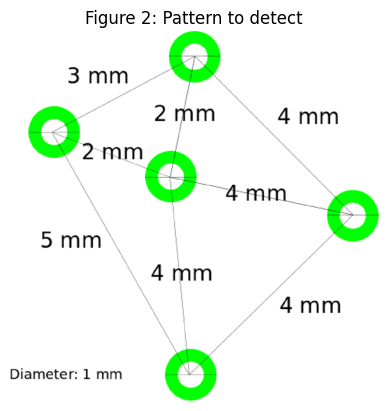

In [4]:
rprt_pattern_a_detecter = io.imread(r"C:\Users\magic\Documents\INSA\GE5\BIP\Projet\5591895-fig-3-source-large.gif")
plt.imshow(rprt_pattern_a_detecter[0,:,:,:3])
plt.title('Figure 2: Pattern to detect')
plt.axis('off')
plt.show()

hii


<Figure size 640x480 with 0 Axes>

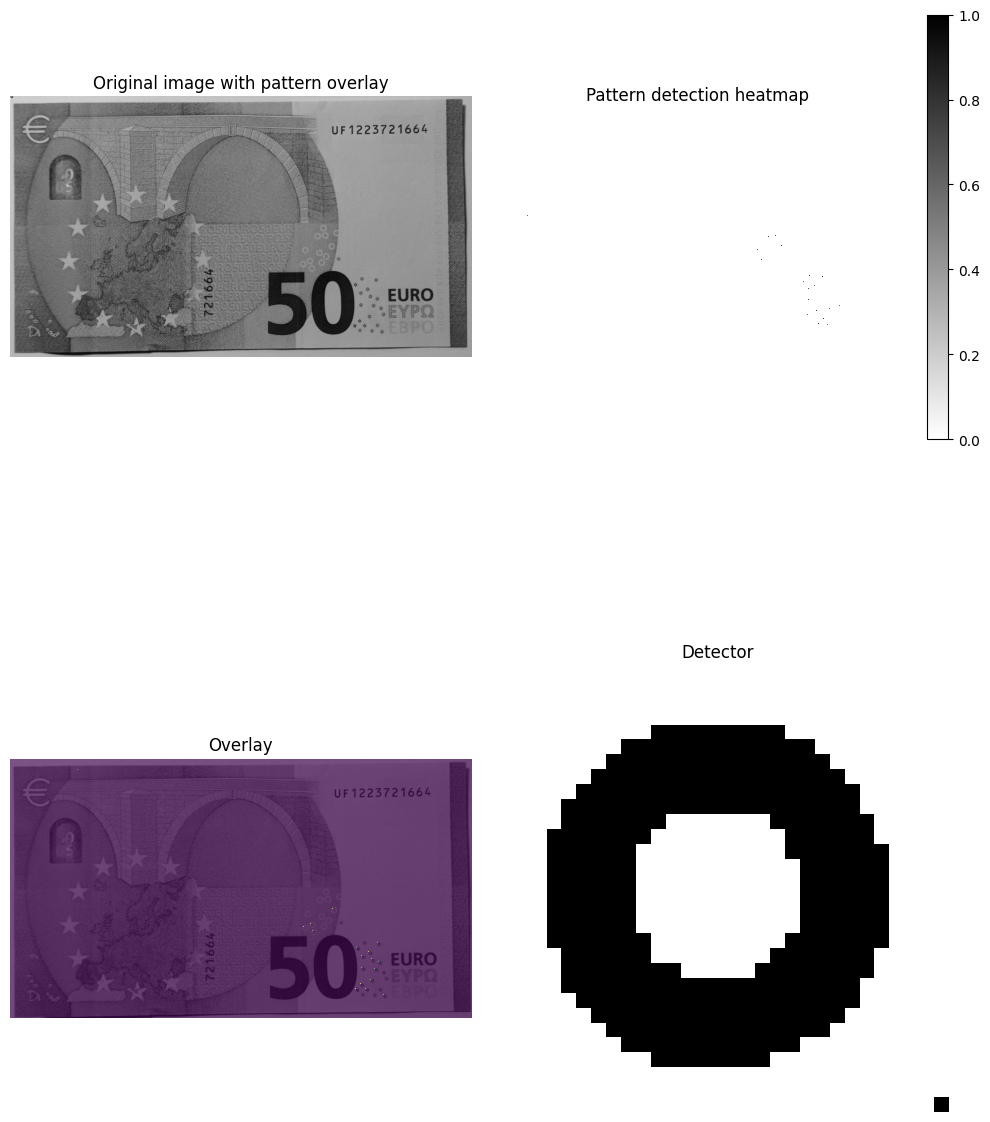

<Figure size 640x480 with 0 Axes>

In [159]:
import skimage.transform as tf


#detect_image = io.imread('EURion_source.png')
detect_image = io.imread('50euros-verso.jpg')
detect_gray = detect_image[:, :, 2] / 255.0
#detect_gray = cl.rgb2gray(detect_image[:,:,:3])


scale_factor = 3
detector = tf.downscale_local_mean(gray_filtered, scale_factor)  # Adjust figure size

# Add the 4th subplot manually
ax4 = fig.add_subplot(1, 4, 4)

# Adjust spacing manually
plt.subplots_adjust(wspace=0.4, hspace=0.4)  # Increase horizontal and vertical spacing)
detector = (detector > 0.5).astype(int)
cross_corr = feat.match_template(detect_gray,detector)

thr = 0.65 * cross_corr.max()
cc_th = cross_corr.copy()
cc_th[cc_th < thr] = 0

plot1 = detect_gray.copy()
h, w = detector.shape
plot1[:h, :w] = detector

print("hii")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,15))

# Original image with pattern overlay (no stretching)
ax1.imshow(plot1, cmap='gray', vmin=0, vmax=1)
ax1.set_title('Original image with pattern overlay')
ax1.axis('off')

# Pattern detection heatmap
im = ax2.imshow(cc_th, cmap='gray_r', vmin=0, vmax=1, interpolation='nearest', origin='upper')
ax2.set_title('Pattern detection heatmap')
ax2.axis('off')
fig.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)

# Overlay without stretching: show cross_corr at its native size (top-left anchored)
ax3.imshow(detect_gray, cmap='gray', vmin=0, vmax=1)
ax3.imshow(cc_th, cmap='viridis', alpha=0.6,
           extent=(0, cross_corr.shape[1], cross_corr.shape[0], 0),
           interpolation='nearest', origin='upper')
ax3.set_title('Overlay')
ax3.axis('off')

# show detector as a subplot (add a 4th subplot in the row)
ax4.imshow(detector, cmap='gray', vmin=0, vmax=1, interpolation='nearest')
ax4.set_title('Detector')
ax4.axis('off')


plt.tight_layout()  # Adjust figure size
plt.show()

# Adjust spacing manually
plt.subplots_adjust(wspace=0.4, hspace=0.4)  # Increase horizontal and vertical spacing

It might not be very visible, but some local maxima were detected using our methodology, close to the known 'star' locations. This validates the first part of our methodology.

## Pattern recognition from maxima positions

The next step in our proposed methodology is to use the detected local maxima positions to compare the distances between 'stars' and compare them to those in Figure 2.

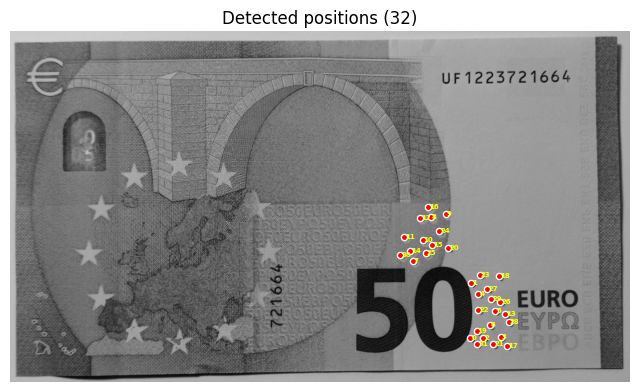

In [160]:
positions = feat.peak_local_max(cross_corr, min_distance=30, threshold_rel=0.8)
positions = np.asarray(positions)

plt.figure(figsize=(8, 8))
plt.imshow(detect_gray, cmap='gray', vmin=0, vmax=1)
if positions.size:
    ys, xs = positions[:, 0], positions[:, 1]
    plt.scatter(xs, ys, c='r', s=20, marker='o', edgecolors='w')
    for i, (y, x) in enumerate(positions):
        plt.text(x + 6, y + 6, str(i), color='yellow', fontsize=5, weight='bold')
plt.title(f'Detected positions ({len(positions)})')
plt.axis('off')
plt.show()

[ 55  55  80 140 144 175 183 222 224 249]
1
1
1
2
1
2
2
1
1
2
1
1
2
Number of groups found: 13


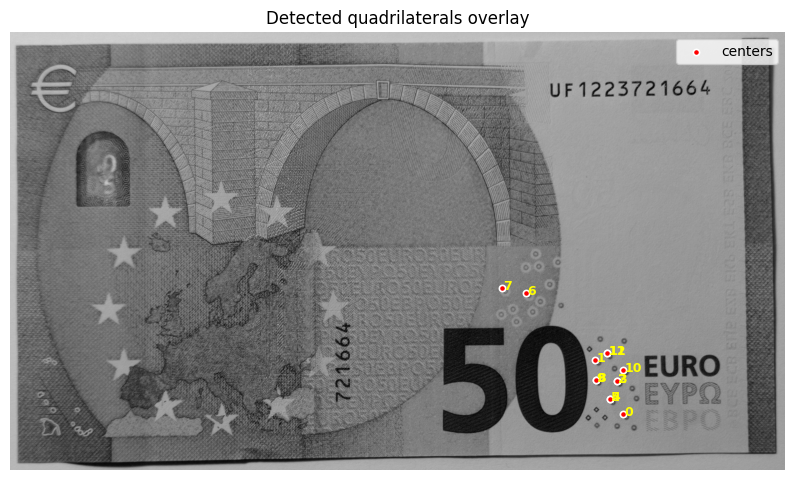

In [ ]:

poss = [64,24,25,1,28,14,32,45]
numb_of_dist = 10
good_enough_dist = 40
good_enough_angle = 14
groupes_a_further = []
all_distances = []
pr = True
centers = []
for star in positions:
    #star = positions[pos]
    #print(pos)
    dist = []
    for star_2 in positions:
        dist.append(int(np.linalg.norm(star - star_2)))
        all_distances.append(int(np.linalg.norm(star - star_2)))
    dist_sorted = np.sort(dist)
    if pr:
        print(dist_sorted[1:1+numb_of_dist])
        pr = False

    
    d_n = dist_sorted[1]
    group_1 = []
    group_2 = []
    for d in dist_sorted[2:2+numb_of_dist]:
        if abs(d_n - d) <= good_enough_dist:
            group_1.append(d)
            if d_n not in group_1:
                group_1.append(d_n)
        elif abs(d - 2 * d_n) <= good_enough_dist:
            group_2.append(d)
    if len(group_1) > 1 and len(group_2) > 1:
        for d in group_1:
            #print(f'group1 : {np.where(dist == d)[0]}')
            pass
        p1 = []
        for i in range(len(group_1)-1):
            for d in group_1[i+1:]:
                p1.append([positions[np.where(dist == group_1[i])[0]], positions[np.where(dist == d)[0]]])
        p2 = []
        for i in range(len(group_2)-1):
            for d in group_2[i+1:]:
                p2.append([positions[np.where(dist == group_2[i])[0]], positions[np.where(dist == d)[0]]])

        # initialize angle flags
        angle_ok_1 = False
        angle_ok_2 = False

        for pair in p1:
            vec_1 = pair[0] - star
            vec_2 = pair[1] - star
            angle = sp.spatial.distance.cosine(vec_1[0], vec_2[0])
            angle = np.degrees((angle))
            #print(f'angle1 {angle}')
            if angle < 60+good_enough_angle and angle > 60-good_enough_angle:
                angle_ok_1 = True
                break
        for pair in p2:
            vec_1 = pair[0] - star
            vec_2 = pair[1] - star
            angle = sp.spatial.distance.cosine(vec_1[0], vec_2[0])
            angle = np.degrees((angle))
            #print(f'angle2 {angle}')
            if angle < 97+good_enough_angle and angle > 97-good_enough_angle:
                angle_ok_2 = True
                break
        if angle_ok_1 and angle_ok_2:
            groupe_detoiles = []
            for d in group_1:
                groupe_detoiles.append(positions[np.where(dist == d)[0]])
            for d in group_2:
                groupe_detoiles.append(positions[np.where(dist == d)[0]])
            print(1)
            groupes_a_further.append(groupe_detoiles)
            centers.append(star)

    d_n = dist_sorted[2]
    group_1 = []
    group_2 = []
    for d in dist_sorted[3:3+numb_of_dist]:
        if abs(d_n - d) <= good_enough_dist:
            group_1.append(d)
            if d_n not in group_1:
                group_1.append(d_n)
        elif abs(d - 2 * d_n) <= good_enough_dist:
            group_2.append(d)
    if len(group_1) > 1 and len(group_2) > 1:
        for d in group_1:
            #print(f'group1 : {np.where(dist == d)[0]}')
            pass
        p1 = []
        for i in range(len(group_1)-1):
            for d in group_1[i+1:]:
                p1.append([positions[np.where(dist == group_1[i])[0]], positions[np.where(dist == d)[0]]])
        p2 = []
        for i in range(len(group_2)-1):
            for d in group_2[i+1:]:
                p2.append([positions[np.where(dist == group_2[i])[0]], positions[np.where(dist == d)[0]]])

        # initialize angle flags
        angle_ok_1 = False
        angle_ok_2 = False

        for pair in p1:
            vec_1 = pair[0] - star
            vec_2 = pair[1] - star
            angle = sp.spatial.distance.cosine(vec_1[0], vec_2[0])
            angle = np.degrees((angle))
            #print(f'angle1 {angle}')
            if angle < 60+good_enough_angle and angle > 60-good_enough_angle:
                angle_ok_1 = True
                break
        for pair in p2:
            vec_1 = pair[0] - star
            vec_2 = pair[1] - star
            angle = sp.spatial.distance.cosine(vec_1[0], vec_2[0])
            angle = np.degrees((angle))
            #print(f'angle2 {angle}')
            if angle < 97+good_enough_angle and angle > 97-good_enough_angle:
                angle_ok_2 = True
                break
        if angle_ok_1 and angle_ok_2:
            groupe_detoiles = []
            for d in group_1:
                groupe_detoiles.append(positions[np.where(dist == d)[0]])
            for d in group_2:
                groupe_detoiles.append(positions[np.where(dist == d)[0]])
            groupes_a_further.append(groupe_detoiles)
            centers.append(star)
            print(2)

    d_n = dist_sorted[3]
    group_1 = []
    group_2 = []
    for d in dist_sorted[4:4+numb_of_dist]:
        if abs(d_n - d) <= good_enough_dist:
            group_1.append(d)
            if d_n not in group_1:
                group_1.append(d_n)
        elif abs(d - 2 * d_n) <= good_enough_dist:
            group_2.append(d)
    if len(group_1) > 1 and len(group_2) > 1:
        for d in group_1:
            #print(f'group1 : {np.where(dist == d)[0]}')
            pass
        p1 = []
        for i in range(len(group_1)-1):
            for d in group_1[i+1:]:
                p1.append([positions[np.where(dist == group_1[i])[0]], positions[np.where(dist == d)[0]]])
        p2 = []
        for i in range(len(group_2)-1):
            for d in group_2[i+1:]:
                p2.append([positions[np.where(dist == group_2[i])[0]], positions[np.where(dist == d)[0]]])

        # initialize angle flags
        angle_ok_1 = False
        angle_ok_2 = False

        for pair in p1:
            vec_1 = pair[0] - star
            vec_2 = pair[1] - star
            angle = sp.spatial.distance.cosine(vec_1[0], vec_2[0])
            angle = np.degrees((angle))
            #print(f'angle1 {angle}')
            if angle < 60+good_enough_angle and angle > 60-good_enough_angle:
                angle_ok_1 = True
                break
        for pair in p2:
            vec_1 = pair[0] - star
            vec_2 = pair[1] - star
            angle = sp.spatial.distance.cosine(vec_1[0], vec_2[0])
            angle = np.degrees((angle))
            #print(f'angle2 {angle}')
            if angle < 97+good_enough_angle and angle > 97-good_enough_angle:
                angle_ok_2 = True
                break
        if angle_ok_1 and angle_ok_2:
            groupe_detoiles = []
            for d in group_1:
                groupe_detoiles.append(positions[np.where(dist == d)[0]])
            for d in group_2:
                groupe_detoiles.append(positions[np.where(dist == d)[0]])
            groupes_a_further.append(groupe_detoiles)
            centers.append(star)
            print(3)

print(f'Number of groups found: {len(groupes_a_further)}')


fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(detect_gray, cmap='gray', vmin=0, vmax=1)
ax.set_title('Detected quadrilaterals overlay')
ax.axis('off')

if centers:
    centers_arr = np.asarray(centers)
    cy = centers_arr[:, 0]
    cx = centers_arr[:, 1]

    ax.scatter(cx, cy, c='red', s=20, edgecolors='white', linewidths=1.2, marker='o', label='centers')

    for i, (x, y) in enumerate(zip(cx, cy)):
        ax.text(x + 6, y + 6, str(i), color='yellow', fontsize=9, weight='bold')

    ax.legend(loc='upper right')
    plt.show()
else:
    print("No center stars to plot.")